In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import mpmath

from ray_delay.device_simulator.noise_model_patch import NoiseModelPatch
from stim_surface_code.memory import MemoryPatch

In [2]:
dx = 7
dz = 7
dm = 7

patch = NoiseModelPatch(MemoryPatch(dx, dz, dm))
patch.noise_model.save_error_vals = True
center_qubit = patch.patch.device[dx][dz].idx

In [3]:
cycles_before_ray = 5*10**3
cycles_after_ray = 5*10**4
ray_radius = 3
batch_size = 5*10**2

In [4]:
# This cell takes about 32 minutes to run

patch.noise_model.reset()
baseline_err_rate = patch.patch.count_logical_errors()[0]
baseline_syndromes = patch.patch.count_detection_events(cycles_before_ray, return_full_data=True)[3]

for i in range(cycles_before_ray // batch_size):
    # so that noise model saves its values
    patch.step(0)

patch.force_cosmic_ray(center_qubit, ray_radius)
err_rates = [baseline_err_rate]*(cycles_before_ray // batch_size)
syndromes = [baseline_syndromes]
for i in range(cycles_after_ray // batch_size):
    err_rates.append(patch.patch.count_logical_errors()[0])
    syndromes.append(patch.patch.count_detection_events(batch_size, return_full_data=True)[3])
    patch.step(patch.patch.cycle_time()*batch_size)

In [5]:
patch.noise_model.active_cosmic_rays[0].affected_qubits

[24, 16, 17, 18, 68, 69, 23, 25, 76, 77, 30, 31, 32]

In [6]:
tlist = np.cumsum([patch.patch.cycle_time()*batch_size]*len(err_rates))
all_syndromes = np.concatenate(syndromes)

In [7]:
averaged_syndromes = [np.mean(all_syndromes[i*batch_size:(i+1)*batch_size]) for i in range(all_syndromes.shape[0]//batch_size)]

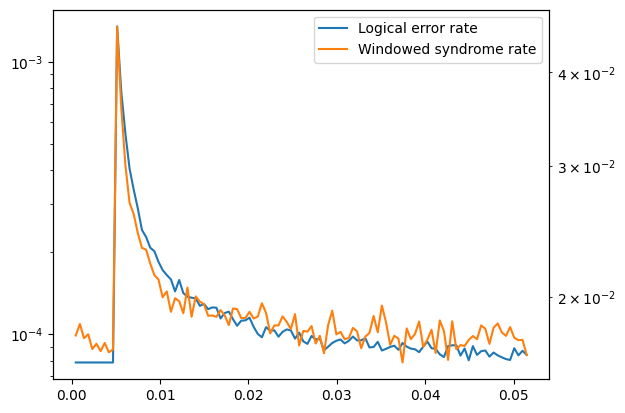

In [8]:
fig,ax = plt.subplots()
ax1 = ax.twinx()

ln = ax.plot(tlist, err_rates, c='C0', label='Logical error rate')
ln1 = ax1.plot(tlist, averaged_syndromes, c='C1', label='Windowed syndrome rate')

# shared legend
lns = ln+ln1
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.set_yscale('log')
ax1.set_yscale('log')

Should somehow quantify how much of an increased logical error rate we can
reliably detect. Find relationship between logical error rate and average
syndrome rate across whole patch, for cosmic rays at random locations on chip.

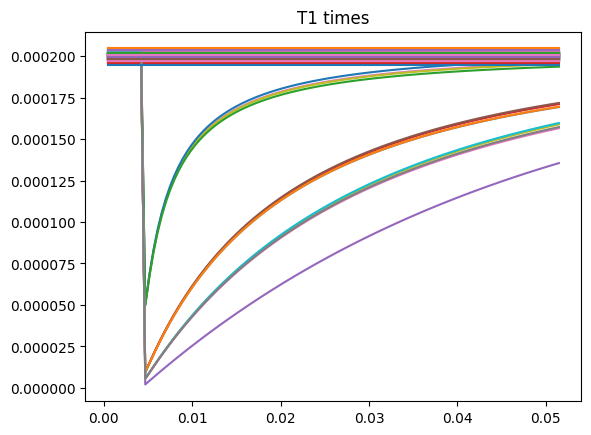

In [9]:
t1_vals = np.array([[vals['T1'][q] for q in range(len(patch.patch.all_qubits))] for vals in patch.noise_model.error_val_history[1:]])
# t1_vals = t1_vals[[0]*(cycles_before_ray // batch_size) + list(range(cycles_after_ray // batch_size))]

plt.plot(tlist, t1_vals)
plt.title('T1 times')
plt.show()